En esta primera sección, se seguirá la discusión del artículo "From the Phenomenology to the Mechanisms of
Consciousness: Integrated Information Theory 3.0".

# Figura 1
Se genera la red de la figura 1 y su matriz de transición. Para esto, primero creamos una matriz de conectividades en la que se defina también el tipo de conexión, es decir, $M_{12}$=x quiere decir que el elemento 1 está conectado con el elemento 2 por la relación x. A continuación se enlistan las relaciones:


0: No hay conexión

1: and

2: or

3: xor

4:copy

In [1]:
Mcon=[0 2 2 2 0 0 ; 1 0 1 0 0 0 ; 3 3 0 0 0 0; 0 0 0 0 0 0 ; 0 4 0 0 0 0 ; 0 0 0 0 0 0 ]; #Genera la matriz de conectividad
Cand=[1, 2, 3]; #Define los elementos candidatos.

#genera el vector de estados de los elementos no candidatos a partir de un vector que los contiene
#SIN TOMAR EN CUENTA LOS ESTADOS CANDIDATO
function bgdstate(ele::Int64,Cand::Array{Int64,1},states::Array{Int64,1})
    x=collect(1:1:ele)
    allstates=zeros(Int64,ele)
    deleteat!(x,Cand)
    for i in 1:size(x)[1]
        allstates[x[i]]=states[i]
    end
    return allstates
end


#genera una matriz con todos los estados posibles, teniendo en cuenta los estados de fondo
function allstate(ele::Int64,Cand::Array{Int64,1},states::Array{Int64,1})
    bgd=bgdstate(ele,Cand,states)
    n=size(Cand)[1]
    x=zeros(Int64,ele,2^n)
    y=zeros(Int64,ele)
    for i in 1:2^n
        for j in 0:n-1
            y[Cand[n-j]]=parse(Int64,bits(i-1)[64-j])
        end
        x[:,i]+=bgd+y
    end
    return x
end



#Da el resultado de aplicar un operador lógico a una serie de enteros
function logicoperator(cod::Int64, A::Array{Int64,1})
        if cod==1
        t0=A[1] & A[2]
        for i in 1:length(A)-2
            t0=t0 & A[i+2]
        end
        elseif cod==2
        t0=A[1] | A[2]
        for i in 1:length(A)-2
            t0=t0 | A[i+2]
        end
        elseif cod==3
        t0=A[1] $ A[2]
        for i in 1:length(A)-2
            t0=t0 $ A[i+2]
        end
        elseif cod==4
        t0=A[1]
        else println(error)
    end
    return t0
end

#Da un paso en el tiempo según el estado y la matriz de conectividad
function timestep(Mcon::Array{Int64,2},state::Array{Int64,1})
    n=length(state)
    x=copy(state) #Matriz que guardará el estado nuevo
    for i in 1:n
        y=Mcon[i,:]
        if sum(y)!=0
            z=find(y.!=0); #Posiciones de ye para entradas no-cero
            cod=y[z[1]];
            A=state[z];#elementos a los cuales se aplicará el operador lógico
            x[i]=logicoperator(cod,A)
        end
    end
    return x
end

#Genera la matriz de transición. Los vectores y columnas se etiqutarán según el número binario que representen
function transition(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1})
    ele=size(Mcon)[1]
    L=2^(length(Cand)[1])
    M=zeros(Int64,L,L)
    states=allstate(ele,Cand,bgdstate)
    for i in 1:L
        y=timestep(Mcon,states[:,i])[Cand];#vector del estado final en los elementos candidatos
        j=parse(Int64,join(y),2)+1;
        M[i,j]=+1
    end
    return M
end



estados=allstate(6,[1,2,3],[0,1,0])
@show A=estados[:,3]
timestep(Mcon,A)[Cand]
M=transition(Mcon,Cand,[0,1,0])


A = estados[:,3] = [0,1,0,0,1,0]


8×8 Array{Int64,2}:
 1  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0
 0  0  0  0  0  1  0  0
 0  0  0  0  0  1  0  0
 0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  1
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  1  0

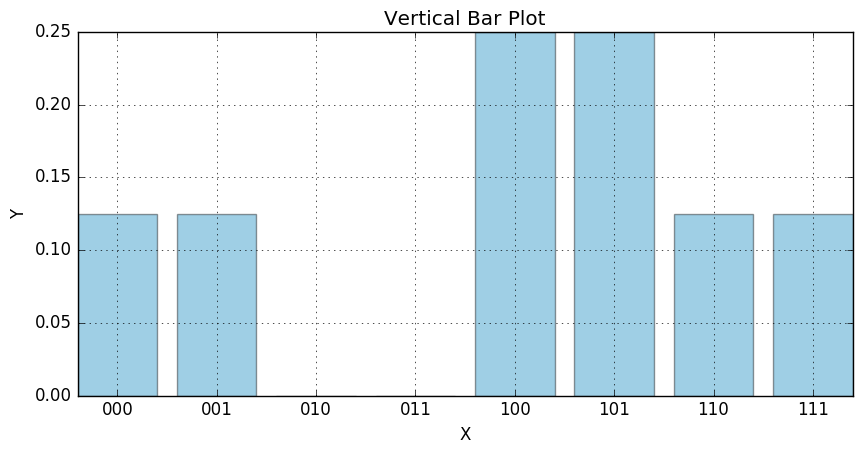

PyObject <matplotlib.text.Text object at 0x7fa81ee58e80>

In [2]:
using PyPlot

function datah(Mat)
    n=size(Mat)[1]
    k=convert(Int64,log2(n))
    y=Array{Int64}(n)
    x=Array{String}(n)
    for i in 1:n
        y[i]=sum(Mat[:,i])
        x[i]=bits(i-1)[65-k:64]
    end
    y=normalize(y,1)
    fig = figure("pyplot_barplot",figsize=(10,10))
    subplot(211)
    b = bar(x,y,color="#0f87bf",align="center",alpha=0.4)
    axis("tight")
    title("Vertical Bar Plot")
    grid("on")
    xlabel("X")
    ylabel("Y")
end

y=datah(M)

# Figura 3
Ahora me enfocaré en reproducir los resultados de la figura 3. Para esto, necesito encontrar la earth mover's distance. Existe un código que encuentra esta distancia, pero este se encuentra escrito en python y no parece nada fácil de transcribir, por lo que necesito usar PyCall. 

In [3]:
using PyCall
@pyimport pyemd
@pyimport numpy as np
A=np.ascontiguousarray([0.0, 1.0])
B=np.ascontiguousarray([5.0, 3.0])
C=np.ascontiguousarray([[0.0,0.5],[0.5,0.0]])
#pyemd.emd(A,B,C);

Esta opción no parece funcionar, pues pyemd.emd parece no recibir los elementos A,B,C como Contiguous. Mejor, hago un script que llama a python desde la terminal. NOTA: Si existe una instalación de Conda.jl, la versión de python que se carga desde la terminal accesada por "run" es esa, por lo que es mejor desinstalar esa chingadera.

In [4]:
using Distances

function matrixtostring(M::Array{Float64,2})
    n=size(M)[1]
    part=M[:,1]
    str="[$part"
    for i in 2:n-1
        part=M[:,i]
        str=join([str,",$part"])
    end
    part=M[:,n]
    str=join([str,",$part]"])
    return str
end

function distancematrix(size::Int64)
    M=Array{Int64}(size,size)
    k=convert(Int64,log2(size))
    for i in 1:size
        for j in 1:size
            M[i,j]=hamming(bits(i-1)[65-k:64].data,bits(j-1)[65-k:64].data)
        end
    end
    return M
end

function emd(histogram1::Array{Float64,1},histogram2::Array{Float64,1})
    n=size(histogram1)[1]
    A="$histogram1"
    B="$histogram2"
    C=matrixtostring(distancematrix(n)*1.0)
    cmd=`/home/humberto/anaconda3/bin/python emd.py $A $B $C`
    parse(Float64,chop(readstring(cmd)))
end;

In [5]:
x=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0];
@show y=normalize([1,1,1,1,1,1,1,0],1);
@show up=normalize(zeros(Float64,8)+1,1);
emd(y,up)

y = normalize([1,1,1,1,1,1,1,0],1) = [0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0]
up = normalize(zeros(Float64,8) + 1,1) = [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125]


0.21428699999999976

# Figura 4
Ahora, sintetizaré toda la información de la figura cuatro en una sola función que calcule la cause-effect information a partir de la matriz de conectividad y la lista de candidatos (que en este caso son todos los elementos). Recordemos:

0: No hay conexión

1: and

2: or

3: xor

4:copy

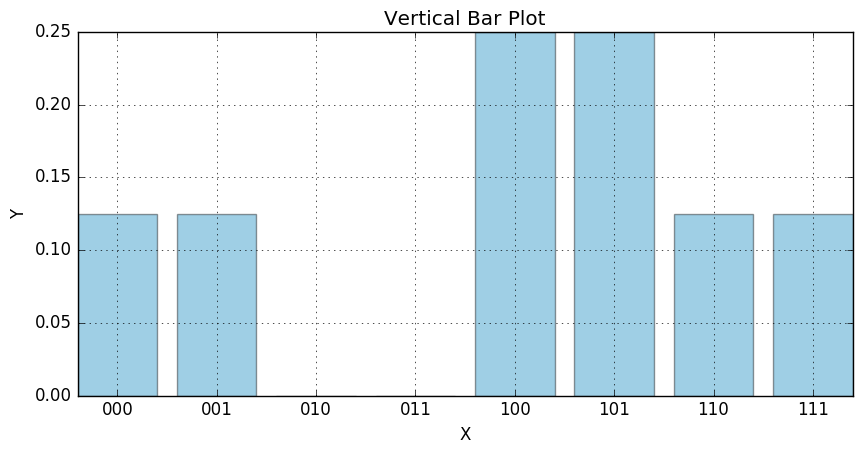

PyObject <matplotlib.text.Text object at 0x7fa81eeef898>

In [6]:
Mcon=[0 2 2; 1 0 1 ;3 3 0];
cand=[1,2,3];
datah(transition(Mcon,cand,[0])) #el último argumento no importa aquí, pues todos los elementos son candidatos.
#El diagrama representa el futuro sin restricciones.

In [7]:
function causeinformation(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1},Constraint::Array{Int64,2})
    M=transition(Mcon,Cand,bgdstate)
    L=size(Cand)[1]
    n=2^L;
    up=normalize(zeros(n)+1,1);
    cr=zeros(n);
    NC=size(Constraint)[1]#Número de constricciones
    foo=zeros(NC)
    for i in 1:n
        nn=find(M[i,:])[1]
        for j in 1:NC
        b=parse(Int64,bits(nn-1)[end-(L-Constraint[j,1])])
            if b==Constraint[j,2]
                foo[j]=1
            end
        end
        foo
        cr[i]=prod(foo)
        foo=zeros(NC)
    end
    normalize!(cr,1)#causerepertoire
    return emd(cr,up)
end

function effectinformation(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1},Constraint::Array{Int64,2})
    ele=size(Mcon)[1]
    L=size(Cand)[1]
    n=2^L;
    M=transition(Mcon,Cand,bgdstate)
    states=allstate(ele,Cand,bgdstate)
    for i in 1:size(Constraint)[1]
        states[Constraint[i,1],:]=Constraint[i,2]
    end
    NE=size(states)[2]#Numero de estados posibles
    er=zeros(n)
    #Matriz que guardara la transicion de los posibles estados
    for i in 1:NE
        y=timestep(Mcon,states[:,i])
        j=parse(Int64,join(y),2)+1;
        er[j]=+1
    end
    normalize!(er,1)#effect repertoire
    uf=Array{Float64}(n)
    for i in 1:n
        uf[i]=sum(M[:,i])
    end
    normalize!(uf,1)#Unconstrained future
    return emd(uf,er)
end
#Para calcular el repertorio de efectos, primero generamos todos los posibles estados que cumplen con el constraint
#y luego calculamos el timestep de estos

#El argumento constraint recibe una matriz con las restricciones que se piden en el presente. Por ejemplo aquí, será 
#[1 1], pues el primer elemento (A) debe estar encendido.

function ceinformation(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1},Constraint::Array{Int64,2})
    A=effectinformation(Mcon,Cand,bgdstate,Constraint)
    B=causeinformation(Mcon,Cand,bgdstate,Constraint)
    min(A,B)
end

causeinformation(Mcon,cand,[0],[1 1;2 1]) #Con este ejemplo vemos que el código funciona para restricciones múltiples
effectinformation(Mcon,[1,2,3],[1],[1 1;2 1]);
ceinformation(Mcon,cand,[1],[1 1])

0.33333858332783356

Al parecer, hay un error en el paper, pues el repertorio de efectos es distinto al que viene hay. Sin embargo, el mío sí concuerda con lo observado según la matriz de transición, que a su vez concuerda con lo previamente mencionado en el paper.

En la siguiente celda usaremos la distribución mostrada (que consiste solo en cambiar 0.25 de 001 a 101) para calcular la EMD entre estas dos.

In [8]:
cf=[0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25]
uf=[0.125,0.125,0.0,0.0,0.25,0.25,0.125,0.125]
emd(cf,uf)

0.50000025

Haciendo esto, vemos que tampoco se genera información de causa reportada. Sin embargo, el resultado calculado por la función emd es correcto.

# Figura 5
En la siguiente celda se prueba el código anterior con los ejemplos de la figura 5

In [24]:
function causeinformation(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1},Constraint::Array{Int64,2})
    M=transition(Mcon,Cand,bgdstate)
    L=size(Cand)[1]
    n=2^L;
    up=normalize(zeros(n)+1,1);
    cr=zeros(n);
    NC=size(Constraint)[1]#Número de constricciones
    foo=zeros(NC)
    for i in 1:n
        nn=find(M[i,:])[1]
        for j in 1:NC
        b=parse(Int64,bits(nn-1)[end-(L-Constraint[j,1])])
            if b==Constraint[j,2]
                foo[j]=1
            end
        end
        foo
        cr[i]=prod(foo)
        foo=zeros(NC)
    end
    normalize!(cr,1)#causerepertoire
    return emd(cr,up)
end

function effectinformation(Mcon::Array{Int64,2},Cand::Array{Int64,1},bgdstate::Array{Int64,1},Constraint::Array{Int64,2})
    ele=size(Mcon)[1]
    L=size(Cand)[1]
    n=2^L;
    M=transition(Mcon,Cand,bgdstate)
    states=allstate(ele,Cand,bgdstate)
    for i in 1:size(Constraint)[1]
        states[Constraint[i,1],:]=Constraint[i,2]
    end
    NE=size(states)[2]#Numero de estados posibles
    er=zeros(n)
    #Matriz que guardara la transicion de los posibles estados
    for i in 1:NE
        y=timestep(Mcon,states[:,i])
        j=parse(Int64,join(y),2)+1;
        er[j]=+1
    end
    @show normalize!(er,1)#effect repertoire
    uf=Array{Float64}(n)
    for i in 1:n
        uf[i]=sum(M[:,i])
    end
    @show normalize!(uf,1)#Unconstrained future
    return emd(uf,er)
end

effectinformation (generic function with 1 method)

In [20]:
Mcon5b=[0 0 0; 1 0 1 ; 2 2 0]
causeinformation(Mcon5b,[1,2,3],[1],[1 1])

normalize!(cr,1) = [0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25]


0.49999950000000004

Esto tampoco corresponde a lo que se ve en el paper, que afirma que el repertorio de causas de A=1 son todos los estados. Esto es incorrecto, pues precisamente porque el elemento A no tiene comunicación con los demás elementos, solo se podrá acceder a este estado cuando en la causa A=1.

In [25]:
effectinformation(Mcon5b,[1,2,3],[1],[1 1])

normalize!(er,1) = [0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5]
normalize!(uf,1) = [0.25,0.25,0.0,0.0,0.0,0.25,0.0,0.25]


0.9999997500000001

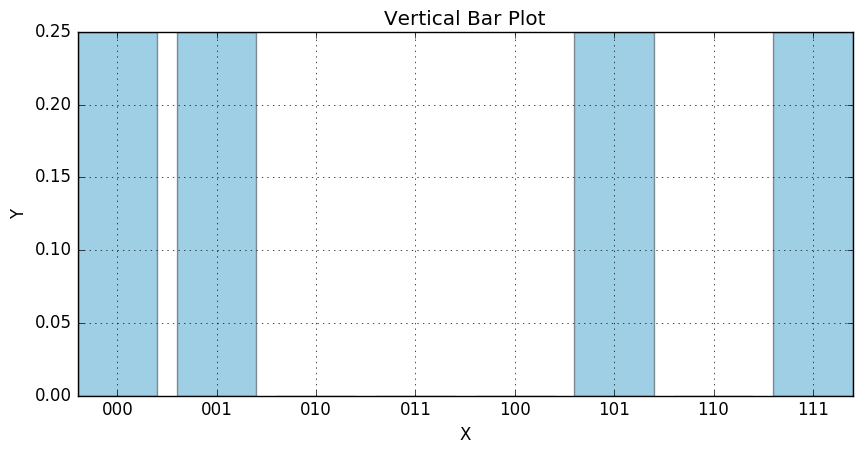

PyObject <matplotlib.text.Text object at 0x7fa81ecdef28>

In [26]:
datah(transition(Mcon5b,[1,2,3],[11]))

# Quantum Integrated Information (QII)

Seguiremos el paper "Integrated Information-induced quantum collapse". Primero, necesitaremos una función que pase de estados tipo $|01\rangle$ a vectores en la base computacional.

In [1]:
"""
El input es un vector en la notación ket y el output un vector en la base computacional.
"""
function quantum_to_vec(quantum_state::Array{Int64,1})
    n=2^length(quantum_state)
    vec=zeros(Int64,n)
    pos=parse(Int64,join(quantum_state),2)+1
    vec[pos]=1
    vec
end

quantum_to_vec

Verifiquemos lo anterior obteniendo la matriz de densidad de un estado puro, en este caso el Greenberger–Horne–Zeilinger (GHZ).
Recordemos que para un estado puro $\rho=|\psi\rangle \langle \psi |$

In [2]:
psi_GHZ=(quantum_to_vec([0,0,0])+quantum_to_vec([1,1,1]))/sqrt(2);
ρGHZ=psi_GHZ*psi_GHZ'

8×8 Array{Float64,2}:
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.5
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.5

## Traza parcial
Hagamos ahora una función de la traza parcial generalizada para cualquier dimensión de sistemas sea cual sea la partición.Para esto traduzco el código 
http://library.wolfram.com/infocenter/MathSource/8763/#downloads
de mathematica language a julia.
Primero, necesito hacer una función que, dado un arreglo y dos posiciones de este, intercambie las partes.

Notemos que la función dTraceSystemSymb se usa cuando la matriz de densidad es un arreglo de strings, mientras que dTraceSystem es para cuando el la matriz de densidad es un arreglo numérico. La notación es como sigue:

Si $\rho_{ABC}$ es el sistema general, entonces, por ejemplo, $\rho_{B}=Tr_{AC}\rho_{ABC}=dTraceSystem(\rho_{ABC},[1,3],dim)$, donde dim=2 si se trata de qubits, dim=3 si son qutrits, dim=d si son qudits.


In [9]:
function SwapParts(expr,pos1::Int64,pos2::Int64)
    expr[pos1], expr[pos2]=expr[pos2], expr[pos1]
    expr
end

function IntegerDigits(n,b,len)
    map(parse,split(base(b,n,len),""))
end

function FromDigits(list,base)
    parse(Int64,join(list),base)
end

function ++(a::Array{String,1},b::Array{String,1})
    c=Array{String}(length(a))
    for i in 1:length(a)
        char1=a[i]
        char2=b[i]
        c[i]="$char1 + $char2"
    end
    c
end
    

++ (generic function with 1 method)

In [10]:
function dTraceSystemSymb(D::Array{String,2}, s, dim)
    Qudits=reverse(sort(s));
    TrkM=D;
    z=length(Qudits)+1;
    q=1;
    while q<z
        n=Int(log(dim,size(TrkM)[1]));
        M=deepcopy(TrkM);
        k=Qudits[q]
        if k==n
            TrkM=[];
            p=1;
            C=[]
            while p<(dim^n)+1
                C=M[p,:][1:dim:dim^n]
                for h in 1:dim-1
                    C=C++M[p+h,:][1+h:dim:dim^n]
                    if p==1
                        append!(TrkM,C)
                    else
                        TrkM=hcat(TrkM,C)
                    end
                end
                p+=dim
            end
            TrkM=permutedims(TrkM,[2,1])
        else
            j=0
            while j<n-k
                b=[0];
                i=1
                while i<(dim^n)+1
                    if IntegerDigits(i-1,dim,n)[n]!=IntegerDigits(i-1,dim,n)[n-j-1] && count(k->(k==i),b)==0
                        b=append!(b,FromDigits(SwapParts((IntegerDigits(i-1,dim,n)),n,n-j-1),dim)+1)
                        c=collect(1:1:dim^n)
                        perm=SwapParts(c,i,FromDigits(SwapParts(IntegerDigits(i-1,dim,n),n,n-j-1),dim)+1)
                        M=M[perm,perm]
                    end
                    i+=1
                end
                j+=1
            end
            TrkM=[];
            p=1
            while p<(dim^n)+1
                C=M[p,:][1:dim:dim^n]
                for h in 1:dim-1
                    C=C++M[p+h,:][1+h:dim:dim^n]
                    if p==1
                        append!(TrkM,C)
                    else
                        TrkM=hcat(TrkM,C)
                    end
                end
                p+=dim
            end
            TrkM=permutedims(TrkM,[2,1])
        end
        q+=1
    end
    return TrkM
end

function dTraceSystem(D, s, dim)
    Qudits=reverse(sort(s));
    TrkM=D;
    z=length(Qudits)+1;
    q=1;
    while q<z
        n=Int(log(dim,size(TrkM)[1]));
        M=deepcopy(TrkM);
        k=Qudits[q]
        if k==n
            TrkM=[];
            p=1;
            C=[]
            while p<(dim^n)+1
                C=M[p,:][1:dim:dim^n]
                for h in 1:dim-1
                    C=C+M[p+h,:][1+h:dim:dim^n]
                    if p==1
                        append!(TrkM,C)
                    else
                        TrkM=hcat(TrkM,C)
                    end
                end
                p+=dim
            end
            TrkM=permutedims(TrkM,[2,1])
        else
            j=0
            while j<n-k
                b=[0];
                i=1
                while i<(dim^n)+1
                    if IntegerDigits(i-1,dim,n)[n]!=IntegerDigits(i-1,dim,n)[n-j-1] && count(k->(k==i),b)==0
                        b=append!(b,FromDigits(SwapParts((IntegerDigits(i-1,dim,n)),n,n-j-1),dim)+1)
                        c=collect(1:1:dim^n)
                        perm=SwapParts(c,i,FromDigits(SwapParts(IntegerDigits(i-1,dim,n),n,n-j-1),dim)+1)
                        M=M[perm,perm]
                    end
                    i+=1
                end
                j+=1
            end
            TrkM=[];
            p=1
            while p<(dim^n)+1
                C=M[p,:][1:dim:dim^n]
                for h in 1:dim-1
                    C=C+M[p+h,:][1+h:dim:dim^n]
                    if p==1
                        append!(TrkM,C)
                    else
                        TrkM=hcat(TrkM,C)
                    end
                end
                p+=dim
            end
            TrkM=permutedims(TrkM,[2,1])
        end
        q+=1
    end
    return convert(Array{Float64,2},TrkM)
end

dTraceSystem (generic function with 1 method)

Trato ahora de comprobar esta función de distintas maneras.|

In [6]:
ρa=["a11" "a12"; "a21" "a22"]
ρb=["b11" "b12"; "b21" "b22"]
ρc=["c11" "c12"; "c21" "c22"]
ρabc=kron(kron(ρa,ρb),ρc)
dTraceSystemSymb(ρabc,[1,3],2)

LoadError: LoadError: MethodError: no method matching ++(::Array{Any,1}, ::Array{Any,1})
while loading In[6], in expression starting on line 5

Veamos si los resultados obtenidos corresponden a los presentados en Integrated Information-induced quantum collapse. Exploremos primero el estado GHZ.

In [11]:
ρGHZ_A=dTraceSystem(ρGHZ,[2,3],2)
ρGHZ_B=dTraceSystem(ρGHZ,[1,3],2)
ρGHZ_C=dTraceSystem(ρGHZ,[1,2],2)
kron(kron(ρGHZ_A,ρGHZ_B),ρGHZ_C)

8×8 Array{Float64,2}:
 0.125  0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 0.0    0.125  0.0    0.0    0.0    0.0    0.0    0.0  
 0.0    0.0    0.125  0.0    0.0    0.0    0.0    0.0  
 0.0    0.0    0.0    0.125  0.0    0.0    0.0    0.0  
 0.0    0.0    0.0    0.0    0.125  0.0    0.0    0.0  
 0.0    0.0    0.0    0.0    0.0    0.125  0.0    0.0  
 0.0    0.0    0.0    0.0    0.0    0.0    0.125  0.0  
 0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.125

In [12]:
ρGHZ_A=dTraceSystem(ρGHZ,[2,3],2)
ρGHZ_BC=dTraceSystem(ρGHZ,[1],2)
A=kron(ρGHZ_A,ρGHZ_BC)

8×8 Array{Float64,2}:
 0.25  0.0  0.0  0.0   0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.25  0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.25  0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0 
 0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.25

In [17]:
ρGHZ

8×8 Array{Float64,2}:
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.5
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.5

In [16]:
logm(A)

8×8 Array{Complex{Float64},2}:
 NaN+0.0im  NaN+0.0im  NaN+0.0im  …  NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im  …  NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im
 NaN+0.0im  NaN+0.0im  NaN+0.0im     NaN+0.0im  NaN+0.0im  NaN+0.0im

Veamos ahora qué pasa con el estado W.

In [13]:
psi_W=(quantum_to_vec([0,0,1])+quantum_to_vec([0,1,0])+quantum_to_vec([1,0,0]))/sqrt(3);
ρW=psi_W*psi_W';
ρW_A=dTraceSystem(ρW,[2,3],2)
ρW_B=dTraceSystem(ρW,[1,3],2)
ρW_C=dTraceSystem(ρW,[1,2],2)
27*kron(kron(ρW_A,ρW_B),ρW_C)

8×8 Array{Float64,2}:
 8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [14]:
ρW_A=dTraceSystem(ρW,[2,3],2)
ρW_BC=dTraceSystem(ρW,[1],2)
9*kron(ρW_A,ρW_BC)

8×8 Array{Float64,2}:
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  2.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  2.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Vemos que todo concuerda con el paper.

## Combinatoria y cálculo de MIP
En este apartado se genran todas las particiones posibles de un sistema

In [121]:
using Combinatorics

INFO: Recompiling stale cache file /home/humberto/.julia/lib/v0.5/Polynomials.ji for module Polynomials.


In [142]:
collect(partitions([1,2,3]))[2:end]

4-element Array{Any,1}:
 Array{Int64,1}[[1,2],[3]]  
 Array{Int64,1}[[1,3],[2]]  
 Array{Int64,1}[[1],[2,3]]  
 Array{Int64,1}[[1],[2],[3]]

En el caso cuántico, el MIP está definido como el ínfimo de la entropía cuántica relativa entre la matriz de densidad del sistema completo y el producto de Kronecker de alguna partición posible del sistema, es decir,
$$\Phi(\rho)=inf(S(\rho|| \otimes^N _{i=1} Tr_{i} (\rho )): {H}=H_1 \otimes ... \otimes H_N )$$
y la entroía cuántica relativa está dada por 
$$S(\sigma_1 || \sigma_2 ) := Tr(\sigma_1 \log(\sigma_1 ))-Tr(\sigma_1 \log(\sigma_2 ))$$
donde $\sigma_1$ y $\sigma_2$ son matrices de densidad. Esta definición es una extensión directa de la entropía de Kullback-Leibler.

Para calcular el logaritmo de una matriz, utilicemos el algoritmo de la wikipedia https://en.wikipedia.org/wiki/Logarithm_of_a_matrix: $\log A = V(\log A') V^{-1}$

In [289]:
function chopnumber(x::Float64, epsilon=10e-15)   
    if abs(x) < epsilon
        return Float64(0)
    else
        return x
    end
end

function chopnumber(y::Array{Float64,2}, epsilon=10e-15) 
    x=copy(y)
    for i=1:length(x)
        x[i]=chopnumber(x[i],epsilon)
    end
    return x
end

function notinf(x::Float64,sust=10e15)   
    if abs(x) == Inf
        return sign(x)*sust
    else
        return x
    end
end

function notinf(y::Array{Float64,2},sust=10e15) 
    x=copy(y)
    for i=1:length(x)
        x[i]=notinf(x[i],sust)
    end
    return x
end

function NaNtozero(y::Array{Complex{Float64},2}) 
    x=copy(y)
    for i=1:length(x)
        if isequal(NaN,abs(x[i]))
            x[i]=0
        end
    end
    return x
end

NaNtozero (generic function with 2 methods)

In [208]:
function quantum_relative_entropy(A,B)
    trace(A*Mlog(A))-trace(A*Mlog(B))
end

quantum_relative_entropy (generic function with 1 method)

In [290]:
NaNtozero(logm(A))

8×8 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im